# Analyze RSD (Relevant Sentence Detection) model

With the fully trained Relevant Sentence model, it is now possible to examine which salient entities are missed when filtering out irrelevant sentences. What is the trade-off and how can the trade-off be controlled such that the salient entities are not missed?

In [21]:
import sys
sys.path.append('..')

import nltk
import numpy as np
from model.relevant_sentence import RSD
from chainer.serializers import load_npz
from util.text import word_to_hash

Now the model is loaded from disk.

In [83]:
vocab_size = 10000
model = RSD(vocab_size, 64, 64)
load_npz('C:\\Users\\kevjac\\Desktop\\thesis_data\\rsd\\out\\model.npz', model)

def sentence_to_features(sentence):
    return [word_to_hash(word, vocab_size) for word in nltk.word_tokenize(sentence)]

A simple function is created to visualize a text such that relevant sentences are colored green and non-relevant sentences are colored red.

In [168]:
from IPython.core.display import display, HTML

def visualize_text(text):
    sentences = nltk.sent_tokenize(text)
    xs = [sentence_to_features(sent) for sent in sentences]
    scores = model.predict(xs).data
    is_relevant = np.argmax(scores, axis=1)
    best_scores = np.max(scores, axis=1)
    relevance_scores = scores[:, 1]
    for r, s1, s2, sent in zip(is_relevant, best_scores, relevance_scores, sentences):
        if s2 > 0.5:
            c_r, c_g, c_b = 0, int(155 * (s2 - 0.5) * 2.0 + 100), 0
            before, after = '<b>', '</b>'
        else:
            c_r, c_g, c_b = int(155 * (1. - 2. * s2) + 100), 100, 100
            before, after = '', ''
        display(HTML('%.1f %s<span style="color: rgb(%d, %d, %d);">%s<span>%s' % (s2, before, c_r, c_g, c_b, sent, after)))

One of the test documents is evaluated and visualized using the model. The scores are the relevance scores. A relevance score of $0.0$ means non-relevant, a relevance score of $0.5$ means confusing and a relevance score of $1.0$ means absolutely relevant.

In [169]:
import os
import json

input_path = "C:\\Users\\kevjac\\Desktop\\thesis_data\\esd\\0_raw_text\\eval"
files = os.listdir(input_path)[100:]
for file in files:
    path = os.path.join(input_path, file)
    with open(path, 'r') as input_file:
        data = json.load(input_file)
        
    print('Abstract')
    print('-' * 100)
    print(data['abstract'])
    print()
    
    print('Text')
    print('-' * 100)
    visualize_text(data['text'])
    break

Abstract
----------------------------------------------------------------------------------------------------
Ronnie Lowenstein heads New York City's Independent Budget Office; office has no policy-making role but provides nonpartisan budget, economic and policy analyses to elected officials and New Yorkers; photo (M)

Text
----------------------------------------------------------------------------------------------------


## Distribution of relevance score

In this section, the distribution of the relevance scores is computed.

### Relevance score for text sentences

This section examines the relevance score for sentences found in the texts.

In [120]:
files = os.listdir(input_path)[:100]
scores = []
for file in files:
    path = os.path.join(input_path, file)
    with open(path, 'r') as input_file:
        data = json.load(input_file)
    sents = nltk.sent_tokenize(data['text'])
    xs = [sentence_to_features(sent) for sent in sents]
    sents_scores = model.predict(xs)[:, 1].data.tolist()
    scores.extend(sents_scores)

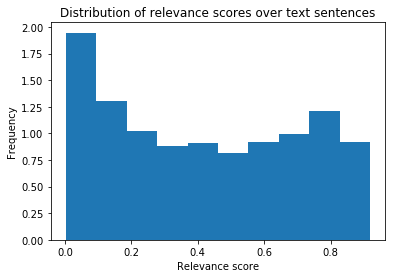

In [123]:
import matplotlib.pyplot as plt
% matplotlib inline

plt.hist(scores, normed=True)
plt.title('Distribution of relevance scores over text sentences')
plt.xlabel('Relevance score')
plt.ylabel('Frequency')

It can be seen that most of the sentences are marked as non-relevant. There is a broad class of sentences that is classified as confusing (with a relevance score of approximately $0.5$).

### Relevance score for abstract sentences

It would be interesting to see how the model classifies sentences in the abstract. These should all be relevant. This section examines the distribution of relevance scores on abstract sentences.

In [124]:
files = os.listdir(input_path)[:100]
scores = []
for file in files:
    path = os.path.join(input_path, file)
    with open(path, 'r') as input_file:
        data = json.load(input_file)
    sents = nltk.sent_tokenize(data['abstract'])
    xs = [sentence_to_features(sent) for sent in sents]
    sents_scores = model.predict(xs)[:, 1].data.tolist()
    scores.extend(sents_scores)

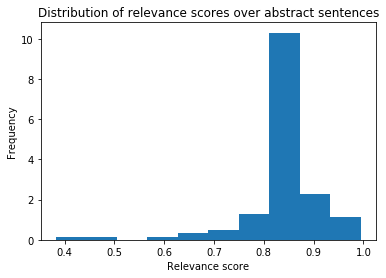

In [125]:
import matplotlib.pyplot as plt
% matplotlib inline

plt.hist(scores, normed=True)
plt.title('Distribution of relevance scores over abstract sentences')
plt.xlabel('Relevance score')
plt.ylabel('Frequency')

As expected, the majority of sentences found in the abstracts are classified as a relevant sentences.

## Relevance score versus recall of salient entities

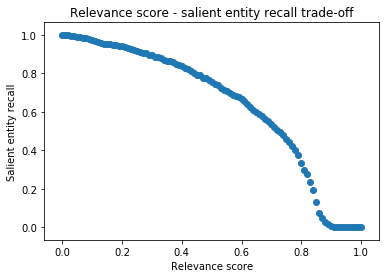

In [163]:
files = os.listdir(input_path)[:100]
scores = []
contained = []
for file in files:
    path = os.path.join(input_path, file)
    with open(path, 'r') as input_file:
        data = json.load(input_file)
    sents = nltk.sent_tokenize(data['text'])
    xs = [sentence_to_features(sent) for sent in sents]
    sents_scores = model.predict(xs)[:, 1].data.tolist()
    salient_entities = [entity['entity'] for entity in data['entities'] if entity['salience']]
    sent_contains_salient_entity = []
    for sent_index, sent in enumerate(sents):
        for entity in salient_entities:
            if entity.lower() in sent.lower():
                sent_contains_salient_entity.append(1)
            else:
                sent_contains_salient_entity.append(0)
            scores.append(sents_scores[sent_index])
    contained.extend(sent_contains_salient_entity)

x_data = []
y_data = []
for x in np.linspace(0., 1., 100 + 1):
    indices = [index for index, score in enumerate(scores) if score >= x]
    hits = sum([contained[index] for index in indices])
    total = sum(contained)
    recall = float(hits) / float(total)
    x_data.append(x)
    y_data.append(recall)

plt.scatter(x_data, y_data)
plt.title('Relevance score - salient entity recall trade-off')
plt.xlabel('Relevance score')
plt.ylabel('Salient entity recall')

x_data_recall = x_data
y_data_recall = y_data

The higher the relevance score, the lower the salient entity recall.

## Relevance score versus compression rate

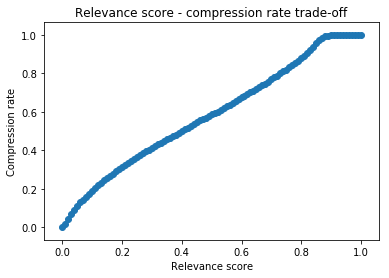

In [164]:
files = os.listdir(input_path)[:100]
scores = []
contained = []
for file in files:
    path = os.path.join(input_path, file)
    with open(path, 'r') as input_file:
        data = json.load(input_file)
    sents = nltk.sent_tokenize(data['text'])
    xs = [sentence_to_features(sent) for sent in sents]
    sents_scores = model.predict(xs)[:, 1].data.tolist()
    scores.extend(sents_scores)
    
x_data = []
y_data = []
for x in np.linspace(0., 1., 100 + 1):
    num_sentences = len([score for score in scores if score <= x])
    total_sentences = len(scores)
    compression_rate = float(num_sentences) / float(total_sentences)
    x_data.append(x)
    y_data.append(compression_rate)
    
plt.scatter(x_data, y_data)
plt.title('Relevance score - compression rate trade-off')
plt.xlabel('Relevance score')
plt.ylabel('Compression rate')

x_data_compression = x_data
y_data_compression = y_data

There is almost a linear relation between the relevance score and the compression rate. It is interesting to choose a relevance score such that the compression rate is high and the salient entity recall is high.

In [166]:
import pandas as pd

rows = []
for i, x in enumerate(np.linspace(0., 1., 100 + 1)):
    rows.append([x, y_data_recall[i], y_data_compression[i]])
df = pd.DataFrame(rows, columns=['relevance', 'recall', 'compression'])

df[(df['recall'] > 0.8) & (df['compression'] > 0.5)]

,relevance,recall,compression
41,0.41,0.828412,0.510811
42,0.42,0.825219,0.518548
43,0.43,0.814046,0.528070
44,0.44,0.803671,0.538385


## Conclusion

So, a relevance score of approximately $0.4$ achieves a compression rate of $0.5$ and a salient entity recall of $0.8$.